## Causality Analysis of Open Covid-19 Epidemiology Data in Madrid
By: Ke Li
Date: March28, 2021

### Process CSV Raw Data

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
project_root      = r"/home/coco/code/dlr/explore_tigramite"

path_to_data_src  = os.path.join(project_root, "src","data")
path_to_model_src = os.path.join(project_root, "src","model")

path_to_processed_data = os.path.join(project_root,"data","processed")
path_to_raw_data       = os.path.join(project_root,"data","raw")

sys.path.insert(0, path_to_data_src)
sys.path.insert(0, path_to_model_src)
sys.path.insert(0, path_to_processed_data)
sys.path.insert(0, path_to_raw_data)

import pandas as pd
import numpy as np

In [2]:
epi = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv")

In [3]:
madrid = epi[epi.key == 'ES_MD']
madrid.tail()

,date,key,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
6190833,2021-04-25,ES_MD,474.0,12.0,NaN,NaN,674447.0,15000.0,NaN,NaN
6206247,2021-04-26,ES_MD,2093.0,14.0,NaN,NaN,676540.0,15014.0,NaN,NaN
6221507,2021-04-27,ES_MD,2346.0,10.0,NaN,NaN,678886.0,15024.0,NaN,NaN
6236676,2021-04-28,ES_MD,1753.0,0.0,NaN,NaN,680639.0,15024.0,NaN,NaN
6250677,2021-04-29,ES_MD,0.0,0.0,NaN,NaN,680639.0,15024.0,NaN,NaN


In [4]:
madrid_np = madrid.values # convert panda dataframe to numpy array

In [6]:
raw_data = np.empty((485,4))
raw_data[:,0] = madrid_np[:,2]
raw_data[:,1] = madrid_np[:,3]
raw_data[:,2] = madrid_np[:,6]
raw_data[:,3] = madrid_np[:,7]


In [7]:
from PrototypeWidgets import ProjectWindow
ProjectWindow().show()

Could not import packages for CMIknn and GPDC estimation
Could not import packages for CMIknn and GPDC estimation


In [8]:
import os
processed_data_folder = r"/home/coco/code/dlr/explore_tigramite/data/processed"
np.savez(os.path.join(processed_data_folder, "kl-01-open_coviddata_epidemiology_madrid.npz"), raw_data) #save data to processed folder


### Causality Analysis with Tigramite

In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline    

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [10]:
# Initialize dataframe object, specify time axis and variable names
#var_names = ["new_confirmed", "new_deceased","total_confirmed","total_deceased"]
var_names = ["c", "d",r'$T_c$',r'$T_d$']
dataframe = pp.DataFrame(raw_data, 
                         datatime = np.arange(len(raw_data)), 
                         var_names=var_names)

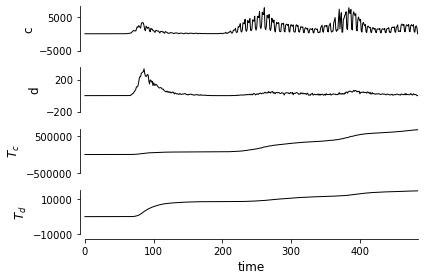

In [11]:
tp.plot_timeseries(dataframe); plt.show()

In [12]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


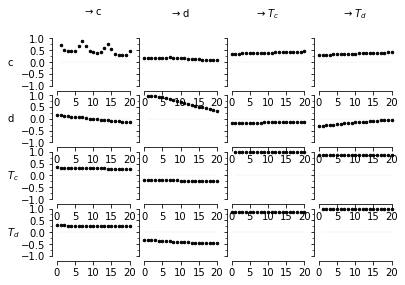

In [13]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [16]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable c has 4 parent(s):
    [pc_alpha = 0.5]
        (c -2): max_pval = 0.20552, min_val = -0.059
        (d -1): max_pval = 0.35529, min_val =  0.043
        ($T_d$ -1): max_pval = 0.44535, min_val =  0.036
        (d -2): max_pval = 0.45871, min_val =  0.035

    Variable d has 3 parent(s):
    [pc_alpha = 0.4]
        (d -2): max_pval = 0.04871, min_val =  0.092
        ($T_c$ -2): max_pval = 0.39131, min_val = -0.040
        ($T_c$ -1): max_pval = 0.39193, min_val = -0.040

    Variable $T_c$ has 4 parent(s):
    [pc_alpha = 0.1]
        ($T_c$ -1): max_pval = 0.00000, min_val =  0.867
        ($T_c$ -2): max_pval = 0.00000, min_val = -0.598
        (c -2): max_pval = 0.06180, min_val = -0.087
        (d -1): max_pval = 0.09518,

In [17]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.   ]
  [0.    0.671 0.008]
  [0.    0.817 0.001]
  [0.    0.71  0.747]]

 [[0.    0.    0.019]
  [1.    0.    0.   ]
  [0.    0.971 0.785]
  [0.    0.647 0.024]]

 [[0.    0.    0.828]
  [0.    0.    0.   ]
  [1.    0.    0.99 ]
  [0.    0.351 0.411]]

 [[0.    0.961 0.999]
  [0.    0.    0.961]
  [0.    0.902 0.271]
  [1.    0.    0.602]]]
MCI partial correlations
[[[ 0.    0.61  0.29]
  [ 0.27 -0.02 -0.13]
  [ 1.   -0.01 -0.16]
  [ 0.24  0.02 -0.02]]

 [[ 0.27  0.2  -0.11]
  [ 0.    0.65  0.68]
  [ 0.26  0.    0.01]
  [ 1.    0.02  0.11]]

 [[ 1.    0.61  0.01]
  [ 0.26  0.19 -0.17]
  [ 0.    0.87 -0.  ]
  [ 0.27  0.04 -0.04]]

 [[ 0.24 -0.   -0.  ]
  [ 1.    0.64 -0.  ]
  [ 0.27 -0.01 -0.05]
  [ 0.    0.88  0.02]]]


In [18]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable c has 7 link(s):
        ($T_c$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (c -1): pval = 0.00000 | qval = 0.00000 | val =  0.609
        ($T_c$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.608
        (c -2): pval = 0.00000 | qval = 0.00000 | val =  0.290
        (d  0): pval = 0.00000 | qval = 0.00000 | val =  0.268
        ($T_d$  0): pval = 0.00000 | qval = 0.00000 | val =  0.242
        (d -1): pval = 0.00002 | qval = 0.00007 | val =  0.199

    Variable d has 8 link(s):
        ($T_d$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (d -2): pval = 0.00000 | qval = 0.00000 | val =  0.685
        (d -1): pval = 0.00000 | qval = 0.00000 | val =  0.647
        ($T_d$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.643
        (c  0): pval = 0.00000 | qval = 0.00000 | val =  0.268
        ($T_c$  0): pval = 0.00000 | qval = 0.00000 | val =  0.258
        ($T_c$ -1): pval = 0.00003 | qval = 0.00010 | va

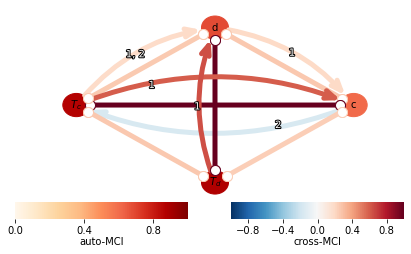

In [19]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

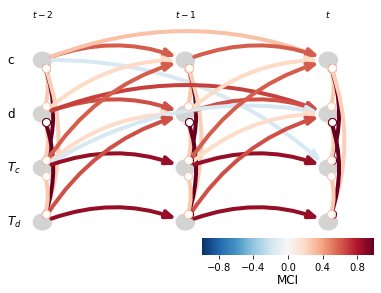

In [20]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

### Make Predictions

In [24]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

T = 464
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(),   #CMIknn ParCorr
        prediction_model = sklearn.linear_model.LinearRegression(),
#         prediction_model = sklearn.gaussian_process.GaussianProcessRegressor(),
        # prediction_model = sklearn.neighbors.KNeighborsRegressor(),
    data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 2 parent(s):
    [pc_alpha = 0.5]
        (0 -2): max_pval = 0.12059, min_val = -0.081
        (1 -1): max_pval = 0.44701, min_val =  0.040

    Variable 1 has 1 parent(s):
    [pc_alpha = 0.05]
        (1 -1): max_pval = 0.00000, min_val =  0.685

    Variable 2 has 2 parent(s):
    [pc_alpha = 0.1]
        (0 -2): max_pval = 0.02784, min_val = -0.115
        (1 -1): max_pval = 0.08189, min_val =  0.091

    Variable 3 has 3 parent(s):
    [pc_alpha = 0.2]
        (3 -1): max_pval = 0.00000, min_val =  1.000
        (3 -2): max_pval = 0.00000, min_val = -0.979
        (0 -1): max_pval = 0.14714, min_val =  0.076


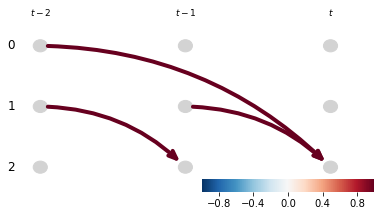

In [26]:
target = 2
tau_max = 2
N = 3
predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=1,
                  tau_max=tau_max,
                  pc_alpha=None
                  )
link_matrix = np.zeros((N, N, tau_max+1), dtype='bool')
for j in [target]:
    for p in predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
#     node_aspect=2.,
    val_matrix=np.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    ); plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 2
tau_max = 30
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 13 parent(s):
    [pc_alpha = 0.5]
        (0 -7): max_pval = 0.00000, min_val =  0.666
        (0 -14): max_pval = 0.01097, min_val = -0.147
        (0 -6): max_pval = 0.10726, min_val =  0.092
        (1 -14): max_pval = 0.13866, min_val = -0.085
        (1 -3): max_pval = 0.17869, min_val = -0.077
        (0 -16): max_pval = 0.20537, min_val = -0.073
        (1 -13): max_pval = 0.27179, min_val = -0.064
        (1 -5): max_pval = 0.29552, min_val = -0.061
        (1 -4): max_pval = 0.31335, min_val = -0.059
        (1 -2): max_pval = 0.31460, min_val = -0.058
        (1 -6): max_pval = 0.35152, min_val =  0.053
        (0 -29): max_pval = 0.47909, min_val = -0.041
        (0 -2): max_pval = 0.49523, min_val =  0.039



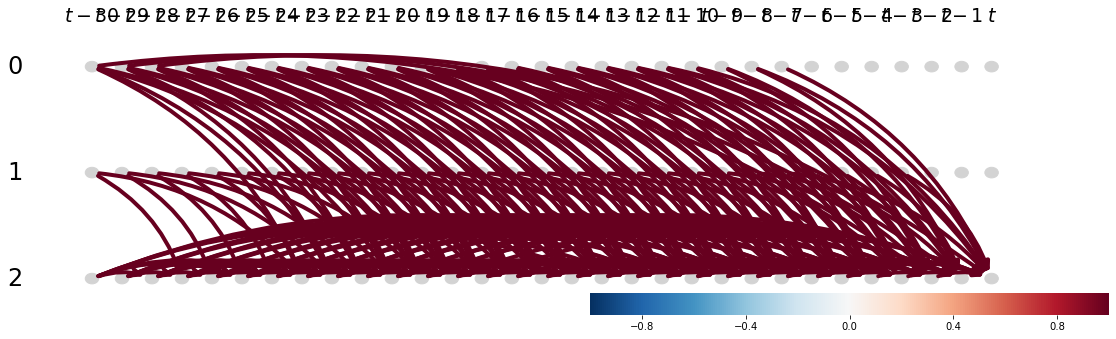

In [27]:
tau_max = 30
steps_ahead = 2
target = 2

all_predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None
                  )
link_matrix = np.zeros((N, N, tau_max + 1), dtype='bool')
for j in [target]:
    for p in all_predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(18, 5),
    node_size=0.05,
    node_aspect=.3,
    val_matrix=np.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    label_fontsize=24
    ); plt.show()

In [28]:
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)


##
## Predicting target 2
##


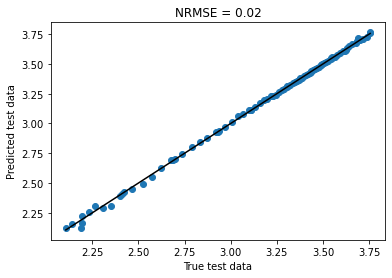

In [29]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

### 

### Evaluation

The user interface should allow the user to find causal relationship, build model, make prediction, and make evaluation based on the tigramite package.

Step 1: Find causal relationship:

Step2:  Build model.

Step3:  Make prediction

Step 4: Perform evaluation


A human-centered design approach:  an iterative process including analysis => design => prototyping  => evaluation